# 聊天机器人评估作为多代理模拟

在构建聊天机器人（例如客户支持助理）时，可能很难正确评估机器人的性能。每次代码更改都必须手动与其进行密集交互，非常耗时。

使评估过程更容易且更具可重复性的一种方法是模拟用户交互。

下面是如何使用 LangGraph.js 创建“虚拟用户”来模拟对话的示例。

整体模拟看起来像这样：

![图表](./img/virtual_user_diagram.png)

首先，我们将设置我们的环境。

In [1]:
// process.env.OPENAI_API_KEY = "sk_...";
// LangSmith 中的可选跟踪
// process.env.LANGCHAIN_API_KEY = "sk_...";
// process.env.LANGCHAIN_TRACING_V2 = "true";
// process.env.LANGCHAIN_PROJECT = "代理模拟评估：LangGraphJS";

## 1. 定义聊天机器人

接下来，我们将定义我们的聊天机器人。此实现使用 OpenAI API 生成响应，并扮演航空公司客户支持代理的角色。

In [2]:
import { ChatOpenAI } from '@langchain/openai'
import type { AIMessageChunk, BaseMessageLike } from "@langchain/core/messages";

const llm = new ChatOpenAI({ model: "gpt-4o-mini" });

async function myChatBot(messages: BaseMessageLike[]): Promise<AIMessageChunk> {
  const systemMessage = {
    role: 'system',
    content: 'You are a customer support agent for an airline.',
  };
  const allMessages = [systemMessage, ...messages];
  
  const response = await llm.invoke(allMessages)
  return response
}

// 测试聊天机器人
const response = await myChatBot([{ role: 'user', content: 'hi!' }]);

console.log(response);

AIMessage {
  "id": "chatcmpl-AE3nMDCiDkmBMSVI6Y6xJBQjjWQwY",
  "content": "Hello! How can I assist you today?",
  "additional_kwargs": {},
  "response_metadata": {
    "tokenUsage": {
      "completionTokens": 9,
      "promptTokens": 23,
      "totalTokens": 32
    },
    "finish_reason": "stop",
    "system_fingerprint": "fp_f85bea6784"
  },
  "tool_calls": [],
  "invalid_tool_calls": [],
  "usage_metadata": {
    "input_tokens": 23,
    "output_tokens": 9,
    "total_tokens": 32
  }
}


## 2. 定义模拟用户

现在我们将定义将与我们的机器人交互的模拟用户。

In [3]:
import { type Runnable } from "@langchain/core/runnables";
import { AIMessage } from "@langchain/core/messages";
import { ChatPromptTemplate } from "@langchain/core/prompts";

async function createSimulatedUser(): Promise<Runnable<{ messages: BaseMessageLike[] }, AIMessage>> {
    const systemPromptTemplate = `You are a customer of an airline company. You are interacting with a user who is a customer support person 
    
{instructions}

If you have nothing more to add to the conversation, you must respond only with a single word: "FINISHED"`;
    
    const prompt = ChatPromptTemplate.fromMessages([
      ['system', systemPromptTemplate],
      ["placeholder", '{messages}'],
    ]);
    
    const instructions = `Your name is Harrison. You are trying to get a refund for the trip you took to Alaska.
You want them to give you ALL the money back. Be extremely persistent. This trip happened 5 years ago.`;

    const partialPrompt = await prompt.partial({ instructions });
    
    const simulatedUser = partialPrompt.pipe(llm);
    return simulatedUser;
}

// 测试模拟用户
const messages = [{role: "user", content: 'Hi! How can I help you?'}];
const simulatedUser = await createSimulatedUser()
const simulatedUserResponse = await simulatedUser.invoke({ messages });
console.log(simulatedUserResponse);

AIMessage {
  "id": "chatcmpl-AE3nNuHpuxAZfG6aQsKoKktitdyfD",
  "content": "Hello! I’m Harrison, and I need to discuss a refund for my trip to Alaska that I took five years ago. I expect all of my money back. Can you assist me with that?",
  "additional_kwargs": {},
  "response_metadata": {
    "tokenUsage": {
      "completionTokens": 40,
      "promptTokens": 108,
      "totalTokens": 148
    },
    "finish_reason": "stop",
    "system_fingerprint": "fp_f85bea6784"
  },
  "tool_calls": [],
  "invalid_tool_calls": [],
  "usage_metadata": {
    "input_tokens": 108,
    "output_tokens": 40,
    "total_tokens": 148
  }
}


## 3. 定义代理模拟

下面的代码创建一个 LangGraph 工作流程来运行模拟。主要组成部分是：

1. 两个节点：一个用于模拟用户，另一个用于聊天机器人。
2. 图表本身，带有条件停止标准。

请阅读下面代码中的注释以获取更多信息。


**节点**

首先，我们定义图中的节点。这些应该接收消息列表并将消息列表返回到 ADD 状态。
这些将是我们上面的聊天机器人和模拟用户的事物包装器。

**注意：** 这里一件棘手的事情是哪些消息是哪些。因为聊天机器人和我们的模拟用户都是法学硕士，所以他们都会用人工智能消息做出回应。我们的状态将是人类和人工智能消息交替出现的列表。这意味着对于其中一个节点，需要某种逻辑来翻转人工智能和人类的角色。在此示例中，我们假设 `HumanMessages` 是来自模拟用户的消息。这意味着我们需要在模拟用户节点中使用一些逻辑来交换人工智能和人类消息。

首先，我们定义聊天机器人节点：

In [4]:
import { MessagesAnnotation } from "@langchain/langgraph";

async function chatBotNode (state: typeof MessagesAnnotation.State) {
  const messages = state.messages
  const chatBotResponse = await myChatBot(messages);
  return { messages: [chatBotResponse] }
}

接下来，让我们为模拟用户定义节点。这将涉及一些交换消息角色的逻辑。

In [5]:
import { BaseMessage, HumanMessage } from "@langchain/core/messages";

// MessagesAnnotation 将所有消息强制为基本消息类
function swapRoles(messages: BaseMessage[]) {
  return messages.map((m) =>
    m instanceof AIMessage
      ? new HumanMessage({ content: m.content })
      : new AIMessage({ content: m.content }),
  )
}

async function simulatedUserNode (state: typeof MessagesAnnotation.State) {
  const messages = state.messages
  const newMessages = swapRoles(messages)
  // 这会直接返回一个可运行的对象，因此我们需要使用下面的`.invoke`：
  const simulateUser = await createSimulatedUser();
  const response = await simulateUser.invoke({ messages: newMessages })

  return { messages: [{ role: "user", content: response.content }] }
}

**边缘**

我们现在需要定义边缘的逻辑。主要逻辑发生在模拟用户离开之后，它应该导致以下两种结果之一：

- 我们要么继续并致电客户支持机器人
- 或者我们结束了，谈话就结束了

那么谈话结束的逻辑是什么？我们将其定义为人类聊天机器人响应 `FINISHED`（请参阅系统提示）或对话长度超过 6 条消息（这是一个任意数字，只是为了保持此示例简短）。

In [6]:
function shouldContinue(state: typeof MessagesAnnotation.State) {
  const messages = state.messages;
  if (messages.length > 6) {
    return '__end__';
  } else if (messages[messages.length - 1].content === 'FINISHED') {
    return '__end__';
  } else {
    return 'continue';
  }
}

**图形**

我们现在可以定义设置模拟的图形！

In [7]:
import { StateGraph, END, START } from "@langchain/langgraph";

function createSimulation() {
  const workflow = new StateGraph(MessagesAnnotation)
    .addNode('user', simulatedUserNode)
    .addNode('chatbot', chatBotNode)
    .addEdge('chatbot', 'user')
    .addConditionalEdges('user', shouldContinue, {
      [END]: END,
      continue: 'chatbot',
    })
    .addEdge(START, 'chatbot')

  const simulation = workflow.compile()
  return simulation;
}

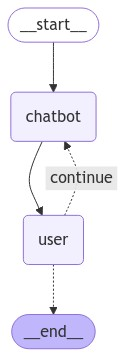

In [8]:
import * as tslab from "tslab";

const drawableGraph = createSimulation().getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## 4. 运行模拟

现在我们可以评估我们的聊天机器人了！我们可以使用空消息调用它（这将模拟让聊天机器人开始初始对话）

In [9]:
async function runSimulation() {
  const simulation = createSimulation()
  for await (const chunk of await simulation.stream({})) {
    const nodeName = Object.keys(chunk)[0];
    const messages = chunk[nodeName].messages;
    console.log(`${nodeName}: ${messages[0].content}`);
    console.log('\n---\n');
  }
}


await runSimulation();

chatbot: How can I assist you today with your airline-related questions or concerns?

---

user: Hi, I'm Harrison, and I'm looking to get a refund for a trip I took to Alaska five years ago. I believe I am entitled to a full refund, and I would like to resolve this matter as soon as possible. Can you help me with that?

---

chatbot: Hi Harrison! I’d be happy to assist you with your request. However, I must inform you that our airline’s refund policy typically covers requests made within a certain timeframe from the date of travel, generally within 12 months for most fares. Since your trip to Alaska was five years ago, it is likely that it falls outside of our standard refund window.

That said, if there were any extraordinary circumstances surrounding your trip or if you have documentation that supports your claim, please provide more details so I can better assist you. If you haven't already, I recommend contacting our customer service team directly through the website or our dedicat